<h1> Notebook to prepare some plots/results analysis of the retrieval pipeline <h1>

In [1]:
import pandas as pd
import numpy as np
import jieba
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from rouge_score import rouge_scorer
from tqdm import tqdm
from rouge_chinese import Rouge as RougeChinese
from rouge import Rouge
import scipy.stats as stats
from datasets import load_dataset
from matplotlib.ticker import FixedLocator, FixedFormatter

TARGET_LANGUAGES = ["en", "es", "de", "ar", "zh", "vi"]
MODELS = ["LaBSE", "BERT multilingual", "Universal Sentence Encoder", "MiniLM", "MPNet", "XLM-RoBERTa"]
LANG_ORDER = ["en", "ar", "de", "es", "vi", "zh"]

Matplotlib created a temporary cache directory at /tmp/matplotlib-5gvkwhm9 because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def calculate_fpr(results_df: pd.DataFrame, threshold: float=0.95) -> float:
    false_positives = (results_df["nearest_neighbor_score"] >= threshold).sum()
    false_positive_rate = np.round(false_positives / len(results_df), 3)
    return false_positive_rate * 100

In [3]:
def count_shared_words_and_set(results):
    shared_words_count = []
    shared_words_list = []
    for index, row in results.iterrows():
        if row["lang"] == "zh" or row["nearest_neighbor_lang"] == "zh":
            answer_words = set(filter(lambda x: x.strip(), jieba.lcut(row["answer"])))
            neighbor_words = set(filter(lambda x: x.strip(), jieba.lcut(row["nearest_neighbor_text"])))
        else:
            answer_words = set(row["answer"].split())
            neighbor_words = set(row["nearest_neighbor_text"].split())
        shared_words = list(answer_words.intersection(neighbor_words))
        shared_words_count.append(len(shared_words))
        shared_words_list.append(shared_words)
    return shared_words_count, shared_words_list

In [4]:
def correlation_nearest_neighbor_length_score(results):
    correlation = results["nearest_neighbor_text"].apply(lambda x: len(x.split(" "))).corr(results["nearest_neighbor_score"])
    return correlation

In [5]:
def plot_correlation_shared_words_score(results):
    shared_words_count, shared_words_list = count_shared_words_and_set(results)
    results["shared_words_between_answer_and_neighbor"] = shared_words_count
    results["shared_words_between_answer_and_neighbor"] = shared_words_count
    sns.scatterplot(x="shared_words_between_answer_and_neighbor", y="nearest_neighbor_score", data=results, alpha=0.5)
    plt.xlabel("Number of shared words between candidate and nearest neighbor")
    plt.ylabel("Nearest Neighbor Score")
    plt.show()

In [6]:
def plot_correlation_nearest_neighbor_length_score(results, dataset_name):
    results["neighbor_text_length"] = results["nearest_neighbor_text"].apply(lambda x: len(x.split()))
    results = results.sample(n=5000, random_state=42)
    correlation, p_value = stats.pearsonr(results["neighbor_text_length"], results["nearest_neighbor_score"])
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x="neighbor_text_length", y="nearest_neighbor_score", data=results, alpha=0.5)
    sns.regplot(x="neighbor_text_length", y="nearest_neighbor_score", data=results, scatter=False, color='orange')
    plt.xlabel("Length of Nearest Neighbor Text", fontweight="bold", fontsize=18)
    plt.ylabel("Nearest Neighbor Score", fontweight="bold", fontsize=18)
    plt.xticks(fontweight="bold", fontsize=16)
    plt.yticks(fontweight="bold", fontsize=16)
    plt.title(f"Correlation: {correlation:.2f} (p-value: {p_value:.2e})")
    plt.xlim(0, 500)
    plt.savefig(f'../data/plots/{dataset_name}_correlation_nearest_neighbor_score.png', dpi=400, bbox_inches='tight')
    plt.show()


In [7]:
def plot_similarity_scores_by_language_overlay(results_df, dataset_name):
    plt.figure(figsize=(14, 8))
    sns.violinplot(x="lang", y="nearest_neighbor_score", hue="model", data=results_df, split=False, inner="quartile", order=LANG_ORDER)
    plt.xlabel("Language", fontweight="bold", fontsize=18)
    plt.ylabel("Similarity Score", fontweight="bold", fontsize=18)
    plt.xticks(fontweight="bold", fontsize=16)
    plt.yticks(fontweight="bold", fontsize=16)
    # plt.legend(title="Model", bbox_to_anchor=(1.45, 0.22))
    plt.legend(title="Model", loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3, fontsize=12, title_fontsize=14)
    plt.savefig(f'../data/plots/{dataset_name}_similarities.png', dpi=400, bbox_inches='tight')
    plt.show()

In [8]:
def calculate_fpr_across_models(results_df, target_languages, target_models):
    thresholds = np.arange(0.1, 1.1, 0.1)
    fpr_data = []
    for model in target_models:
        for lang in target_languages:
            for threshold in thresholds:
                fpr = calculate_fpr(results_df[(results_df["lang"] == lang) & (results_df["model"] == model)], threshold)
                fpr_data.append({"model": model, "lang": lang, "threshold": threshold, "fpr": fpr})

    return pd.DataFrame(fpr_data)


In [9]:
def fpr_for_specific_languages_models(results_df):
    fpr_data = []
    for model in results_df["model"].unique():
        for lang in results_df["lang"].unique():
            language_model_results = results_df[(results_df["lang"] == lang) & (results_df["model"] == model)]
            fpr = calculate_fpr(language_model_results)
            fpr_data.append({"model": model, "lang": lang, "fpr": fpr})

    return pd.DataFrame(fpr_data)

In [10]:
def plot_fpr_rates_across_thresholds(fpr_df, dataset_name):
    g = sns.FacetGrid(fpr_df, col="lang", hue="model", col_wrap=3, height=4, aspect=1.5)
    g.map(sns.lineplot, "threshold", "fpr", marker="o")
    g.set_axis_labels("Threshold", "False Positive Rate (%)", fontweight="bold", fontsize=12)
    g.set_titles("Language: {col_name}", fontweight="bold", fontsize=14)

    xticks = np.arange(0.1, 1.1, 0.1)
    for axis in g.axes.flat:
        axis.tick_params(labelleft=True, labelbottom=True)
        axis.set_xticklabels(axis.get_xticks(), fontweight="bold", fontsize=10)
        axis.set_yticklabels(axis.get_yticks(), fontweight="bold", fontsize=10)
        axis.xaxis.set_major_locator(FixedLocator(xticks))
        axis.yaxis.set_major_locator(FixedLocator(axis.get_yticks()))
        axis.xaxis.set_major_formatter(FixedFormatter([f'{tick:.1f}' for tick in xticks]))
        axis.yaxis.set_major_formatter(FixedFormatter([f'{tick:.0f}' for tick in axis.get_yticks()]))
        axis.set_ylim(-1, 100)
        axis.axhline(y=1, color='mediumvioletred', linestyle='--', linewidth=1)
        axis.text(0.5, 0.03, "Critical Level", ha='center', va='bottom', color='mediumvioletred',transform=axis.get_xaxis_transform(), fontweight='bold', fontsize=10)
    

    g.add_legend(title="Model", bbox_to_anchor=(1.05, 0.5), loc='center right', fontsize=14, frameon=True)
    plt.subplots_adjust(top=0.9, hspace=0.2, wspace=0.1)
    plt.setp(g._legend.get_title(), fontsize=20)
    g.set(xlim=(0.095, 1))
    plt.savefig(f"../data/plots/{dataset_name}_fpr_across_thresholds.png", bbox_inches="tight", dpi=400)
    plt.show()

In [11]:
def plot_language_fprs(fpr_df):
    g = sns.FacetGrid(fpr_df, col="model", col_wrap=3, height=4, aspect=1.5, sharey=False)
    g.map_dataframe(sns.barplot, x="lang", y="fpr", dodge=False)
    g.set_axis_labels("Language", "False Positive Rate (%)")
    g.set_titles("Model: {col_name}")
    
    for axis in g.axes.flat:
        axis.tick_params(labelleft=True, labelbottom=True)
        
    plt.subplots_adjust(top=0.9, right=0.8)
    plt.tight_layout()
    plt.show()


In [12]:
def plot_different_language_neighbors(language_percentages_df, dataset_name):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=language_percentages_df, x="lang", y="percentage", hue="model", palette="muted", order=LANG_ORDER)
    plt.xlabel("Language", fontweight="bold", fontsize=16)
    plt.ylabel("Percentage of neighbors in different language", fontweight="bold", fontsize=16)
    plt.xticks(fontweight="bold", fontsize=14)
    plt.yticks(fontweight="bold", fontsize=14)
    plt.ylim(0, 100)
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.savefig(f"../data/plots/{dataset_name}_nearest_neighbor_percentage.png", dpi=400)
    plt.show()

In [13]:
def percentage_different_language_nearest_neighbor(results_df):
    language_percentages = []
    for model in results_df["model"].unique():
        model_results = results_df[results_df["model"] == model]
        for lang in model_results["lang"].unique():
            language_results = model_results[model_results["lang"] == lang]
            different_language_count = sum(language_results["lang"] != language_results["nearest_neighbor_lang"])
            total_count = len(language_results)
            percentage = (different_language_count / total_count) * 100
            language_percentages.append({"lang": lang, "model": model, "percentage": percentage})
    
    return pd.DataFrame(language_percentages)

<h1> Visualizations of OASST2 evaluation <h1>

In [193]:
datasets = glob.glob("../data/retrieval_results/oasst2*.csv")
dfs = []
for dataset, model in zip(datasets, MODELS):
    print(dataset, model)
    df = pd.read_csv(dataset, index_col=0)
    df["model"] = model
    dfs.append(df)

../data/retrieval_results/oasst2_filtered_LaBSE.csv LaBSE
../data/retrieval_results/oasst2_filtered_bert-base-multilingual-cased.csv BERT multilingual
../data/retrieval_results/oasst2_filtered_distiluse-base-multilingual-cased-v2.csv Universal Sentence Encoder
../data/retrieval_results/oasst2_filtered_paraphrase-multilingual-MiniLM-L12-v2.csv MiniLM
../data/retrieval_results/oasst2_filtered_paraphrase-multilingual-mpnet-base-v2.csv MPNet
../data/retrieval_results/oasst2_filtered_xlm-roberta-base.csv XLM-RoBERTa


In [194]:
full_results_oasst = pd.concat(dfs)
full_results_oasst.reset_index(drop=True, inplace=True)

<h2> Distribution of similarity scores across languages <h2>

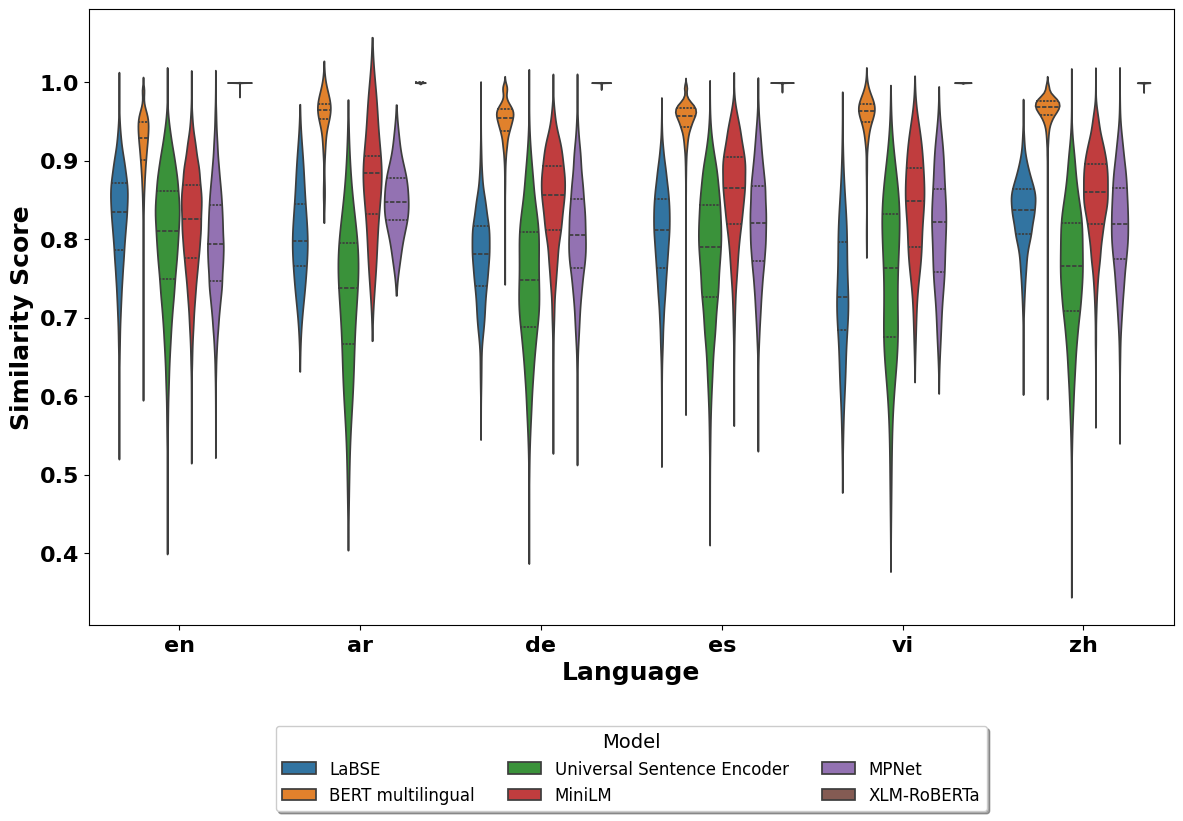

In [199]:
plot_similarity_scores_by_language_overlay(full_results_oasst, dataset_name="oasst")

<h2> Correlation between nearest neighbor length and similarity score <h2>

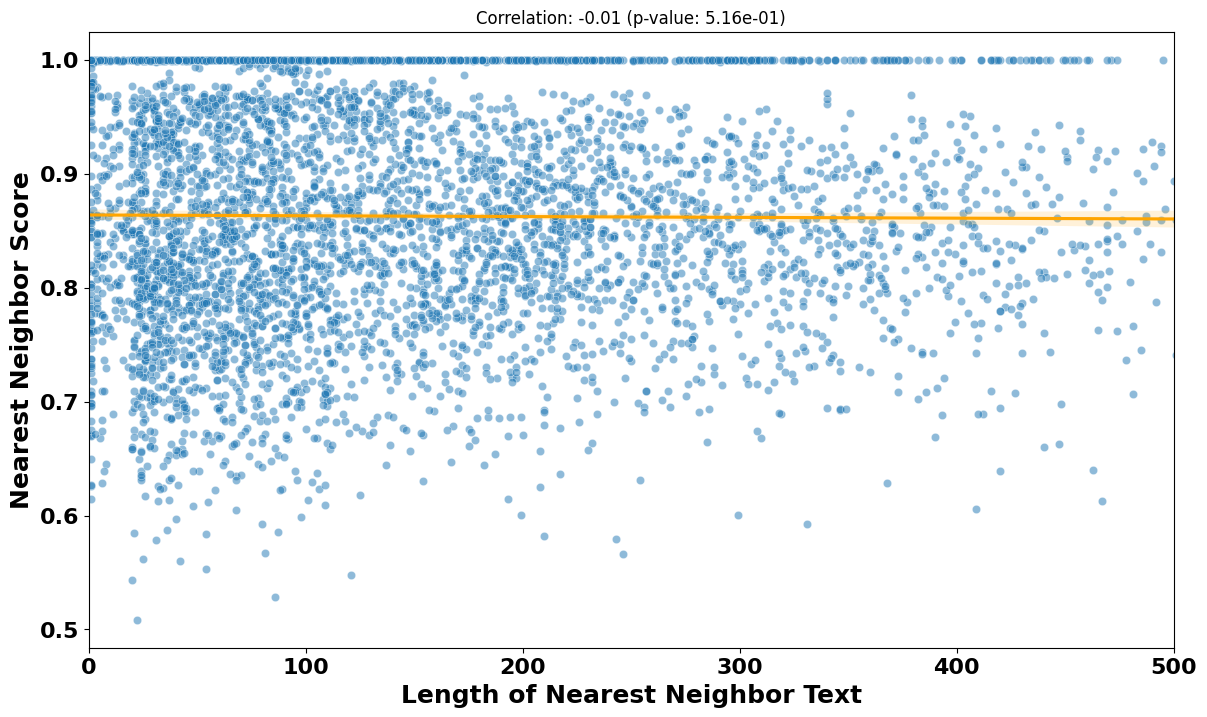

In [200]:
plot_correlation_nearest_neighbor_length_score(full_results_oasst, dataset_name="oasst")

<h2> FPR across different languages, models, and thresholds (acceptable FPR = 1%) <h2>

/tmp/ipykernel_45258/2626101478.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(axis.get_xticks(), fontweight="bold", fontsize=10)
/tmp/ipykernel_45258/2626101478.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(axis.get_yticks(), fontweight="bold", fontsize=10)


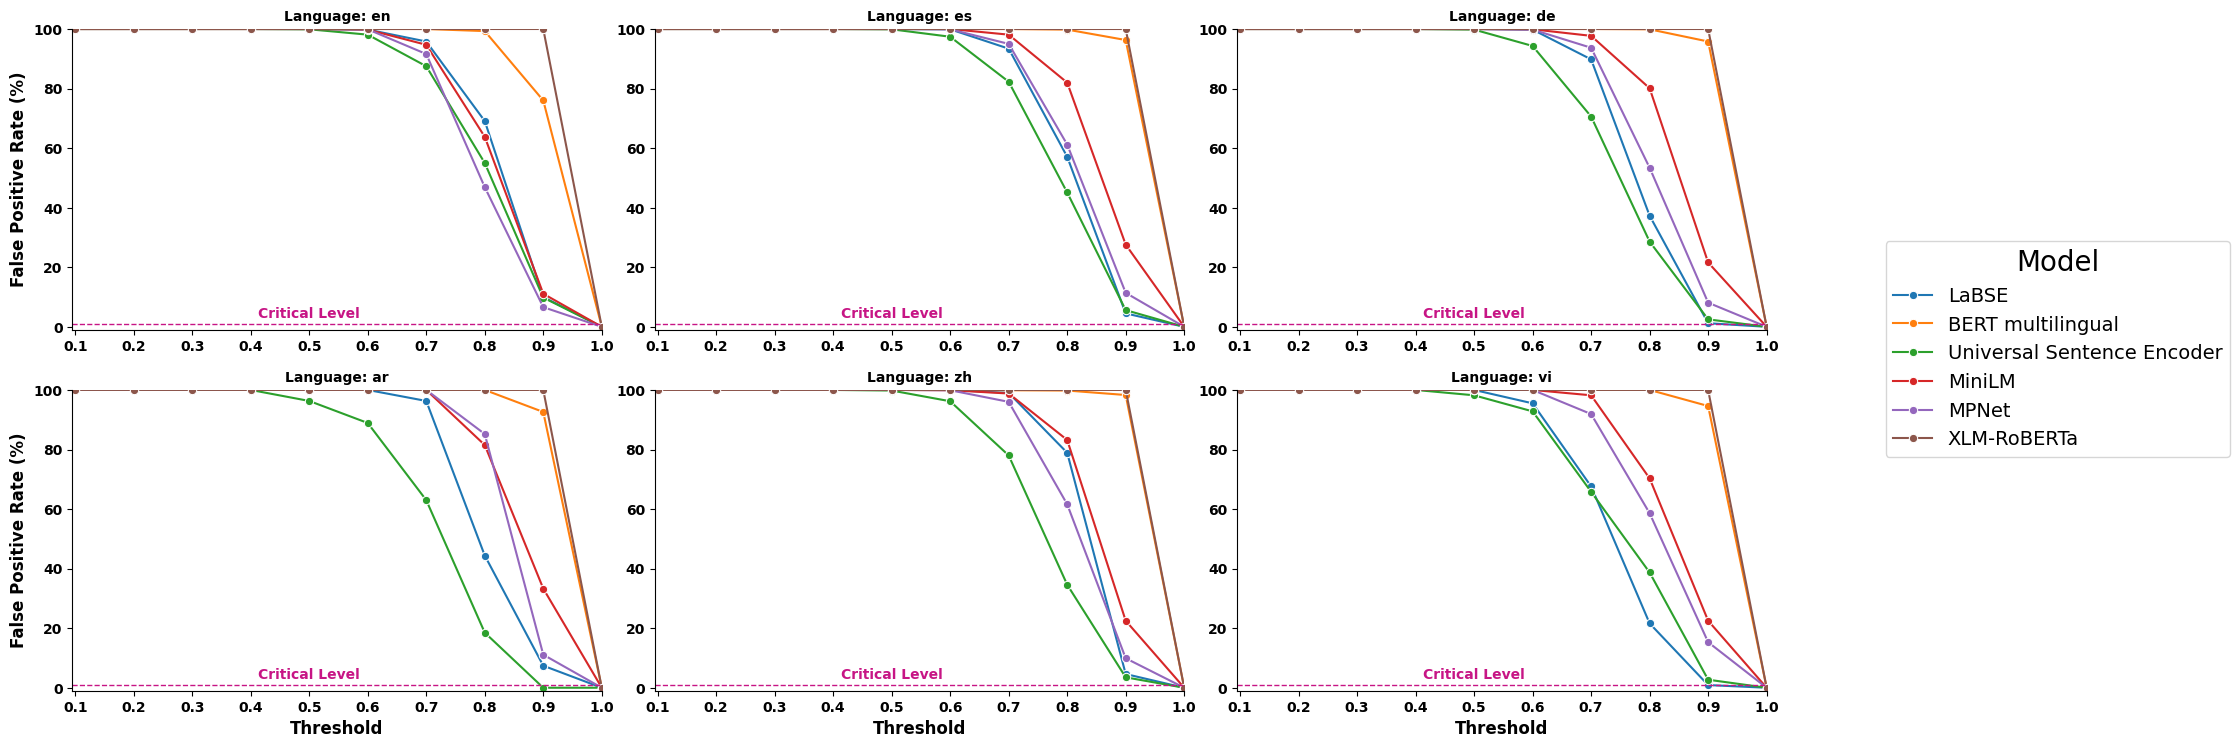

In [201]:
fpr_df_models = calculate_fpr_across_models(full_results_oasst, TARGET_LANGUAGES, MODELS)
plot_fpr_rates_across_thresholds(fpr_df_models, dataset_name="oasst")

<h2> FPR across different languages and models <h2>

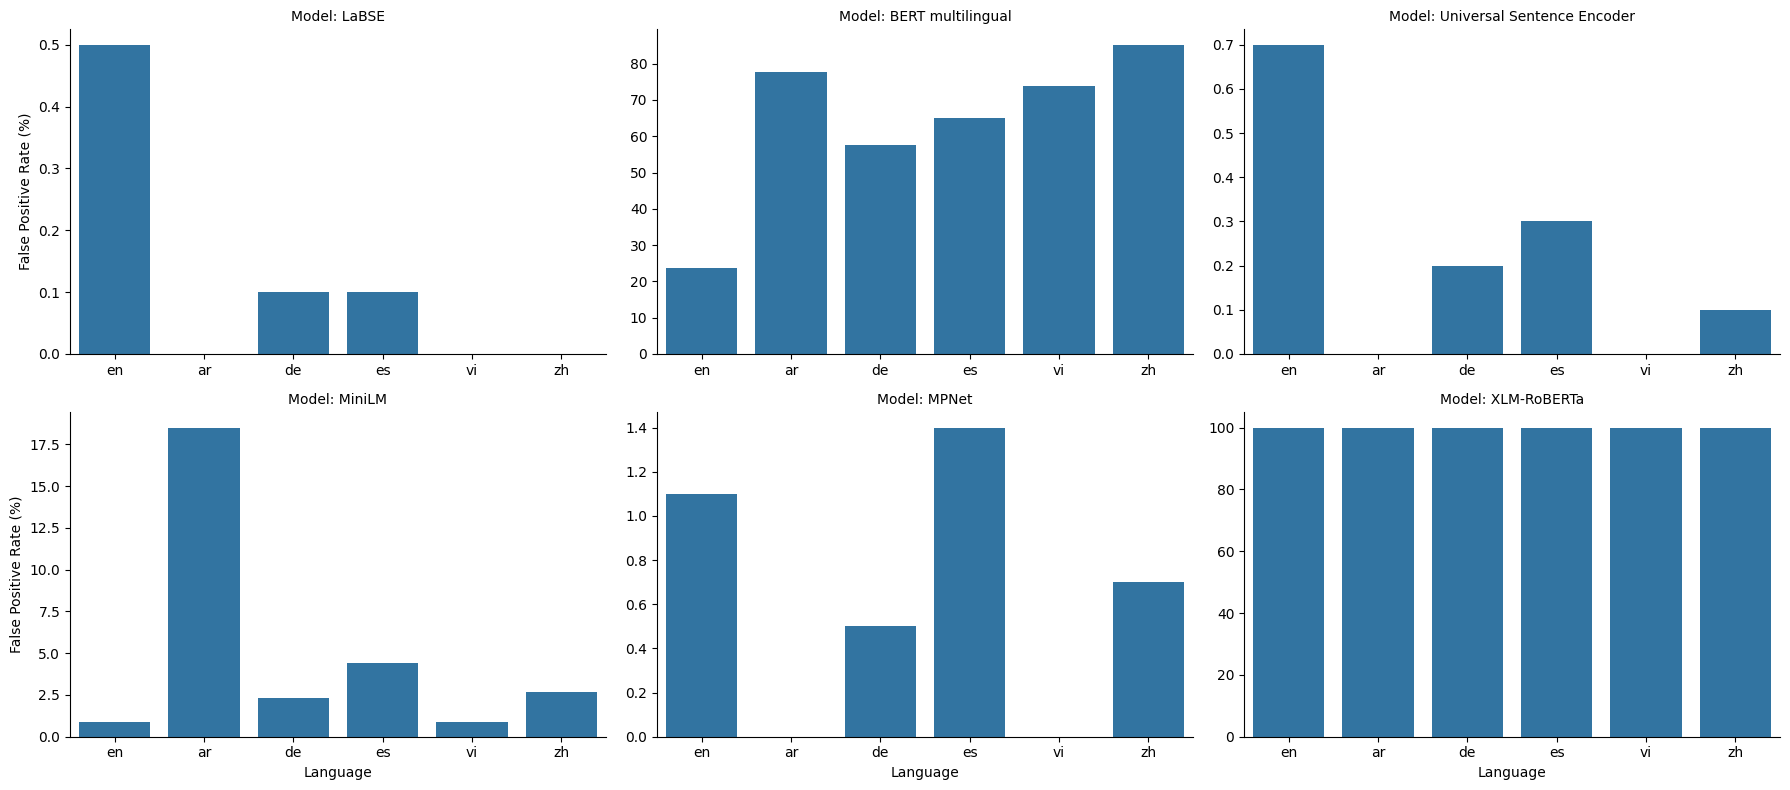

In [203]:
fpr_df_languages_models = fpr_for_specific_languages_models(full_results_oasst)
plot_language_fprs(fpr_df_languages_models)

<h2> Percentange of situations where nearest neigbhor was in different language than original text <h2>

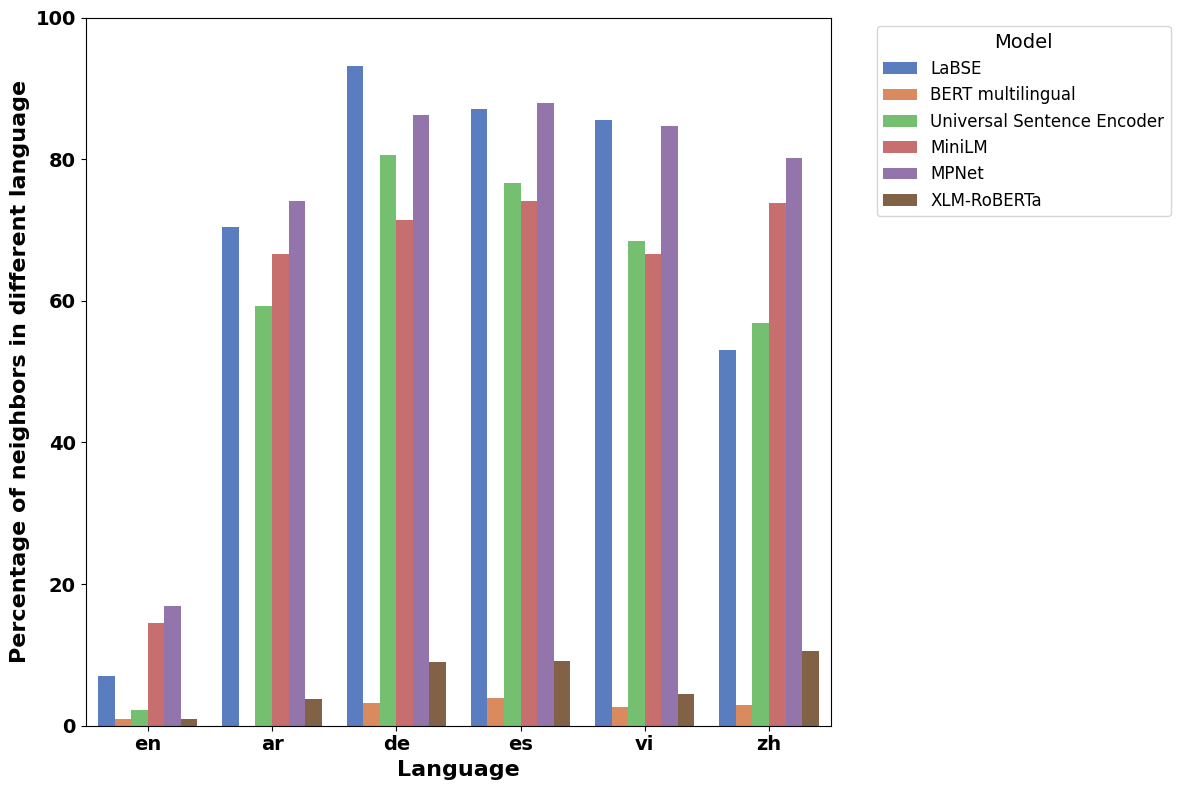

In [204]:
language_percentages_df = percentage_different_language_nearest_neighbor(full_results_oasst)
plot_different_language_neighbors(language_percentages_df, dataset_name="oasst")

<h2> Rouge metrics <h2>

In [207]:
def calculate_rouge_scores(results_df):
    scores = []
    rouge_scorer = Rouge()
    rouge_scorer_chinese = RougeChinese()
    
    for model in tqdm(MODELS):
        model_results = results_df[results_df["model"] == model]
        filtered_results = model_results[model_results["lang"] == model_results["nearest_neighbor_lang"]]
        
        for idx, row in filtered_results.iterrows():
            if row["lang"] != "zh":
                reference = row["answer"]
                hypothesis = row["nearest_neighbor_text"]
                rouge_scores = rouge_scorer.get_scores(hypothesis, reference)
                rouge1 = rouge_scores[0]["rouge-1"]["r"]
                rouge2 = rouge_scores[0]["rouge-2"]["r"]
            else:
                reference = ' '.join(jieba.lcut(row["answer"]))
                hypothesis = ' '.join(jieba.lcut(row["nearest_neighbor_text"]))
                rouge_scores = rouge_scorer_chinese.get_scores(hypothesis, reference)
                rouge1 = rouge_scores[0]["rouge-1"]["r"]
                rouge2 = rouge_scores[0]["rouge-2"]["r"]
                
            scores.append({
                "answer": reference,
                "nearest_neighbor_text": hypothesis,
                "model": model,
                "lang": row["lang"],
                "nearest_neighbor_score": row["nearest_neighbor_score"],
                "rouge1": rouge1,
                "rouge2": rouge2,
            })

    return pd.DataFrame(scores)

In [208]:
def plot_rouge_scores(results_df, dataset_name):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

    # Bar plot for ROUGE-2 scores
    sns.barplot(
        data=results_df,
        ax=ax1,
        x='model',
        y='rouge2',
        hue='lang',
        palette='muted',
        hue_order=LANG_ORDER,
        ci=False
    )
    ax1.set_xlabel('Model', fontweight="bold", fontsize=12)
    ax1.set_ylabel('Rouge2 Score', fontweight="bold", fontsize=12)
    # ax1.set_ylim(0, 0.45)
    ax1.tick_params(axis='x')
    # Remove the individual legend
    ax1.legend_.remove()

    # Bar plot for ROUGE-1 scores
    sns.barplot(
        data=results_df,
        ax=ax2,
        x='model',
        y='rouge1',
        hue='lang',
        palette='muted',
        hue_order=LANG_ORDER,
        ci=False
    )
    
    ax2.set_xlabel('Model', fontweight="bold", fontsize=12)
    ax2.set_ylabel('Rouge1 Score', fontweight="bold", fontsize=12)
    # Remove the individual legend
    ax2.legend_.remove()

    # Create the shared legend
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', title='Language', ncol=3, fontsize=12, title_fontsize=14, bbox_to_anchor=(0.9, 0.93))
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.savefig(f"../data/plots/{dataset_name}_rouge_scores.png", dpi=400, bbox_inches='tight')

    # Show the plot
    plt.show()

In [209]:
rouge_df = calculate_rouge_scores(full_results_oasst)

100%|██████████| 6/6 [1:49:48<00:00, 1098.06s/it]  


/tmp/ipykernel_45258/72091400.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(
/tmp/ipykernel_45258/72091400.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(


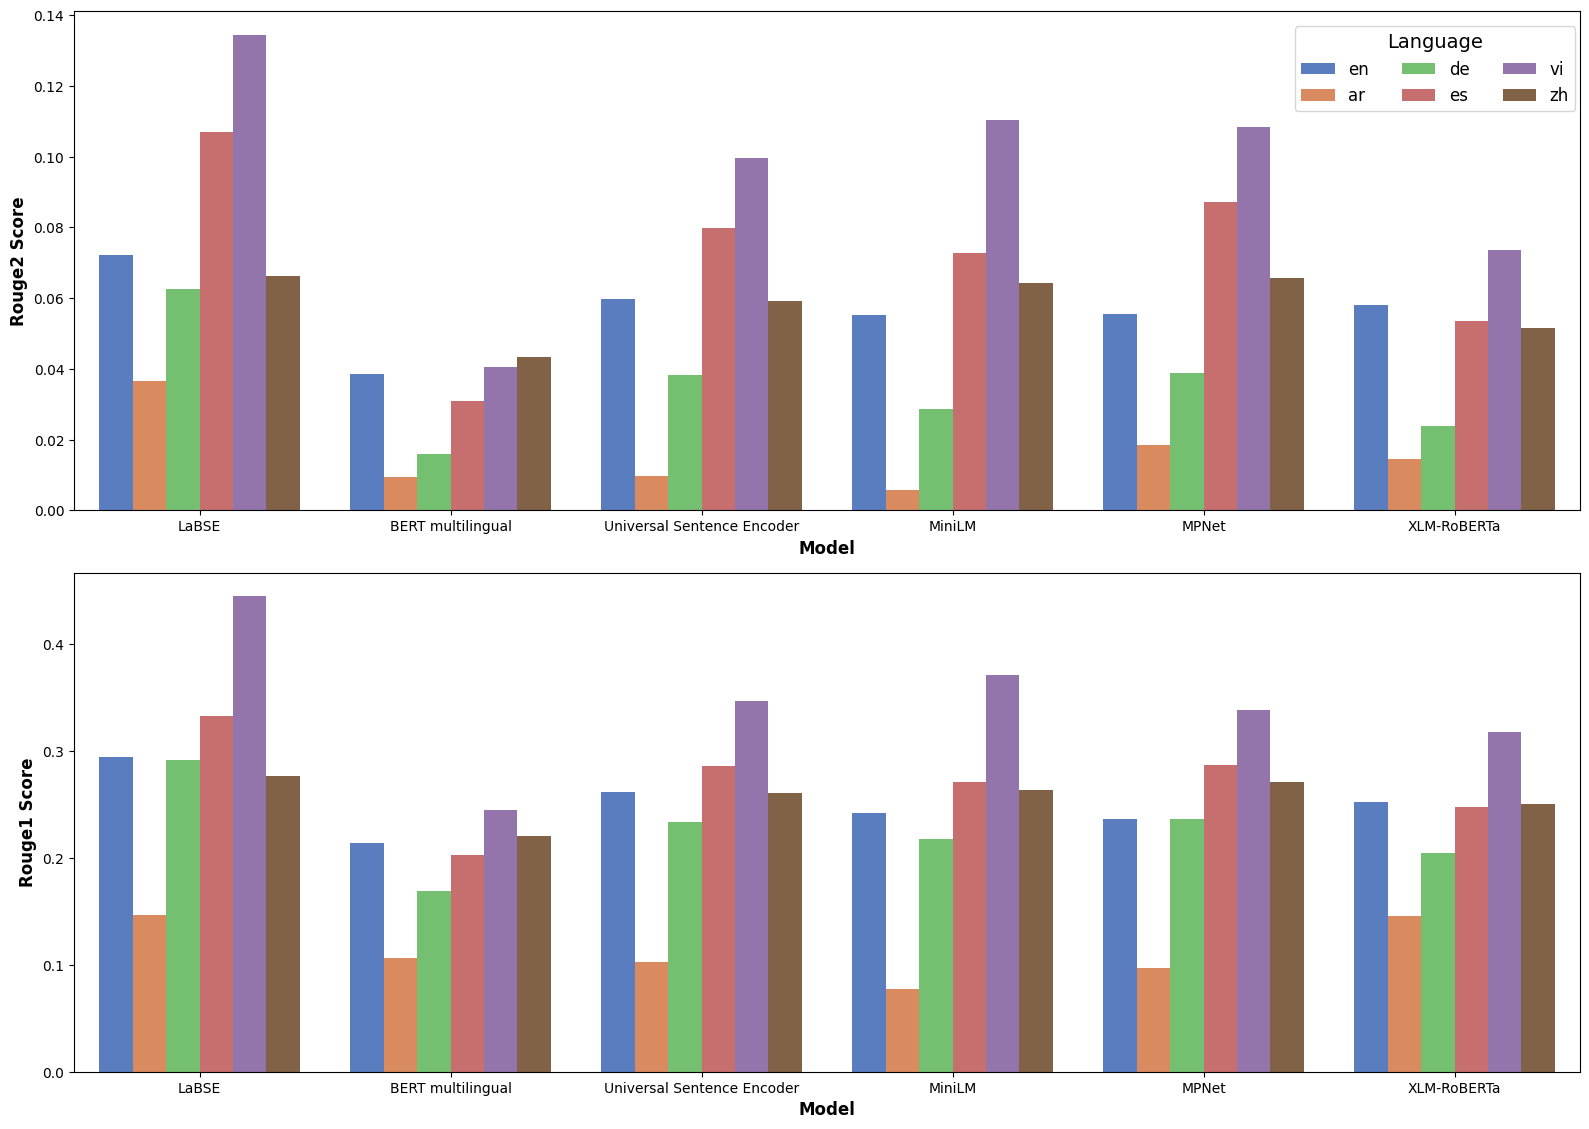

In [210]:
plot_rouge_scores(rouge_df, dataset_name="oasst")

<h1> Visualizations of MLQA evaluation <h1>

In [153]:
datasets = glob.glob("../data/retrieval_results/mlqa*.csv")
dfs = []
for dataset, model in zip(datasets, MODELS):
    print(dataset, model)
    df = pd.read_csv(dataset, index_col=0)
    df["model"] = model
    dfs.append(df)

../data/retrieval_results/mlqa_filtered_LaBSE.csv LaBSE


../data/retrieval_results/mlqa_filtered_bert-base-multilingual-cased.csv BERT multilingual
../data/retrieval_results/mlqa_filtered_distiluse-base-multilingual-cased-v2.csv Universal Sentence Encoder
../data/retrieval_results/mlqa_filtered_paraphrase-multilingual-MiniLM-L12-v2.csv MiniLM
../data/retrieval_results/mlqa_filtered_paraphrase-multilingual-mpnet-base-v2.csv MPNet
../data/retrieval_results/mlqa_filtered_xlm-roberta-base.csv XLM-RoBERTa


In [154]:
full_results_mlqa = pd.concat(dfs)
full_results_mlqa.reset_index(drop=True, inplace=True)

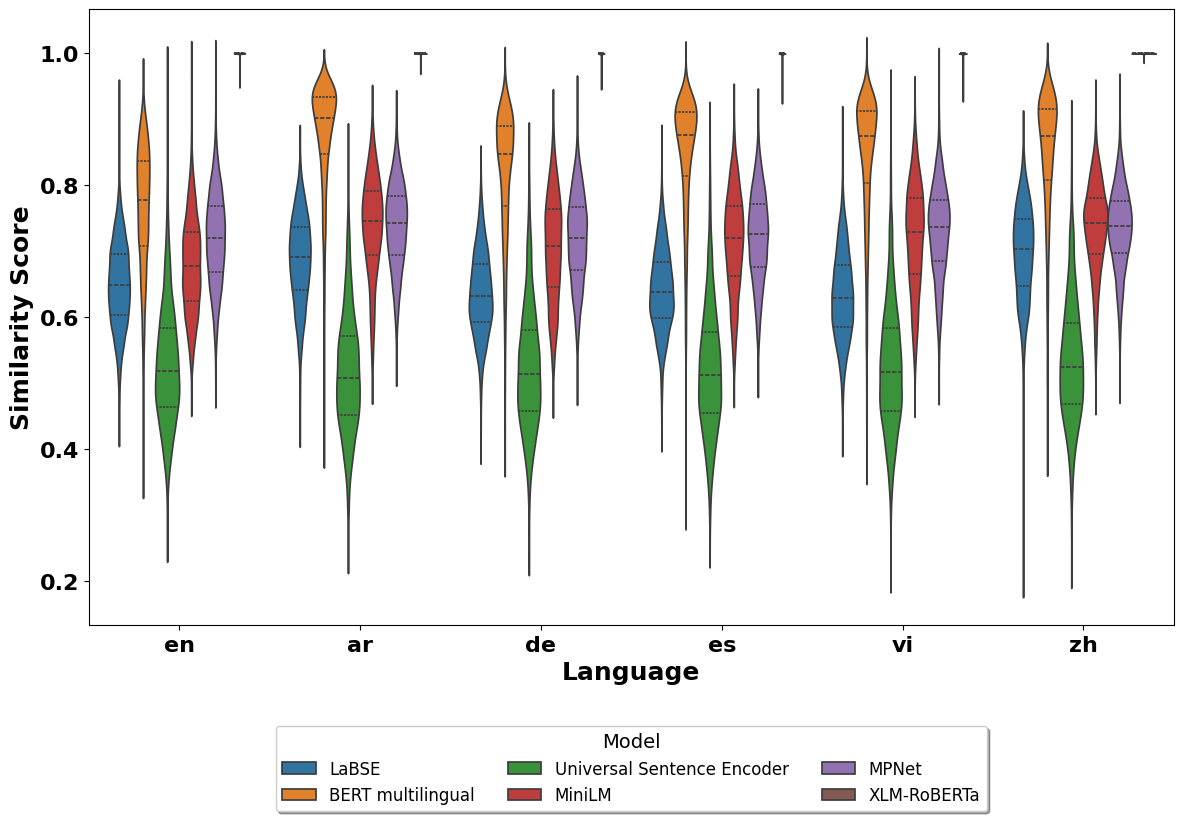

In [155]:
plot_similarity_scores_by_language_overlay(full_results_mlqa, "mlqa")

/tmp/ipykernel_45258/2626101478.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(axis.get_xticks(), fontweight="bold", fontsize=10)
/tmp/ipykernel_45258/2626101478.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(axis.get_yticks(), fontweight="bold", fontsize=10)


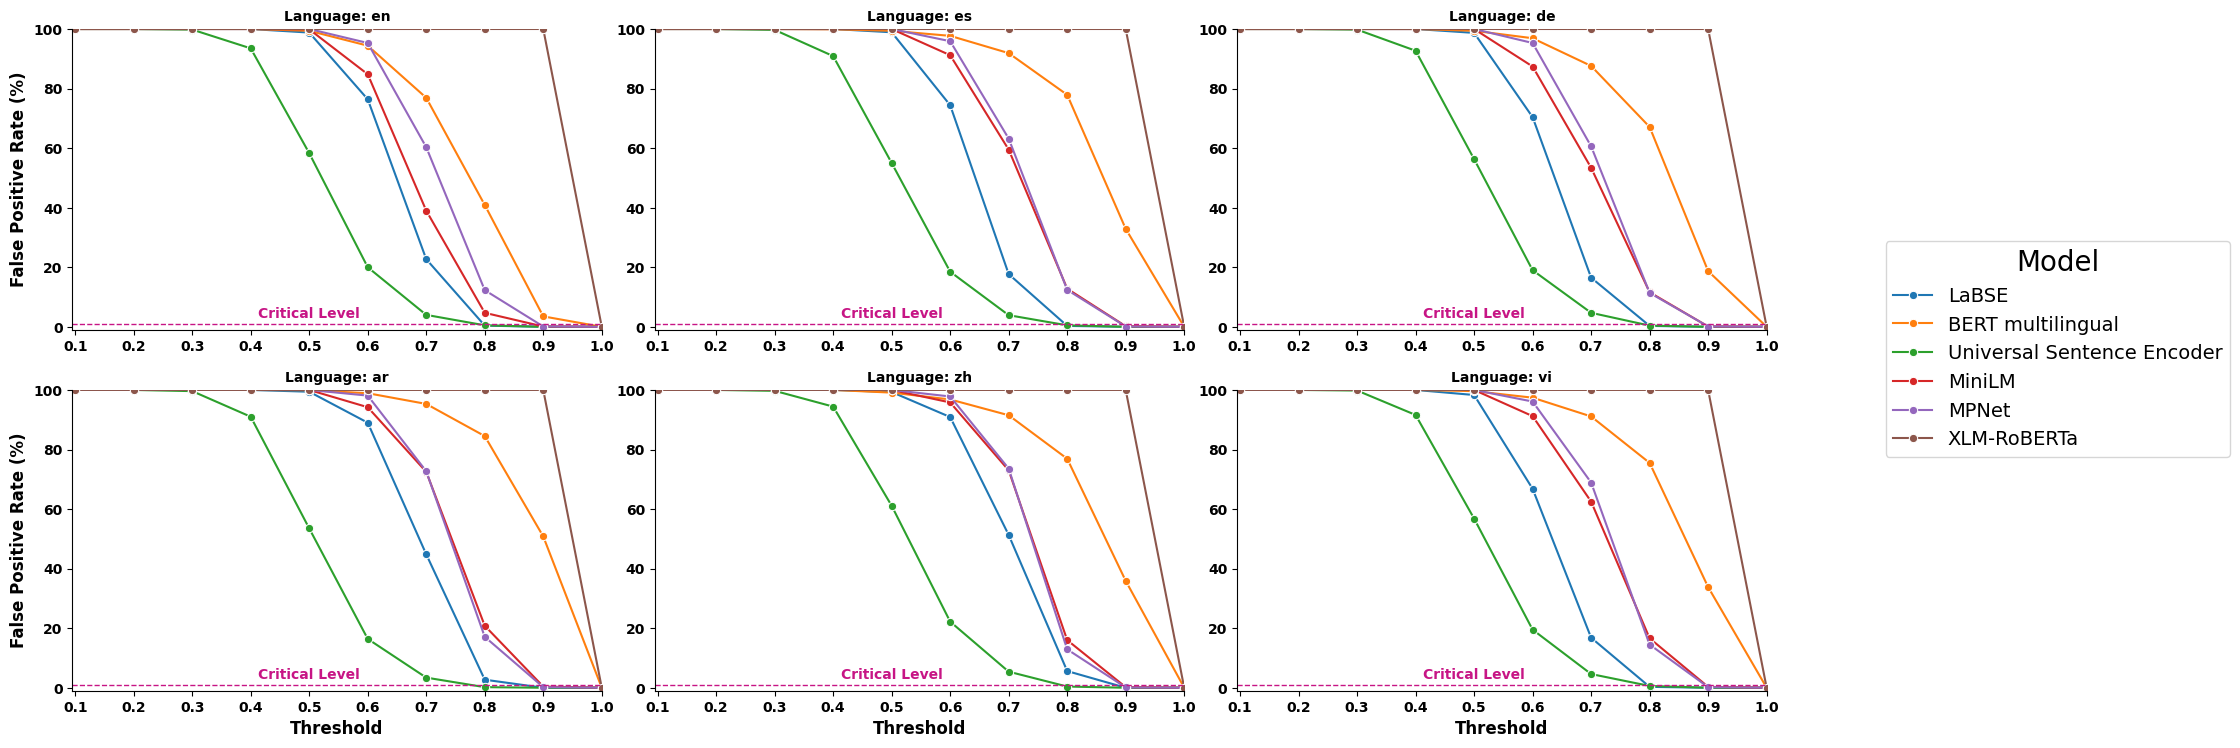

In [175]:
fpr_df_models = calculate_fpr_across_models(full_results_mlqa, TARGET_LANGUAGES, MODELS)
plot_fpr_rates_across_thresholds(fpr_df_models, "mlqa")

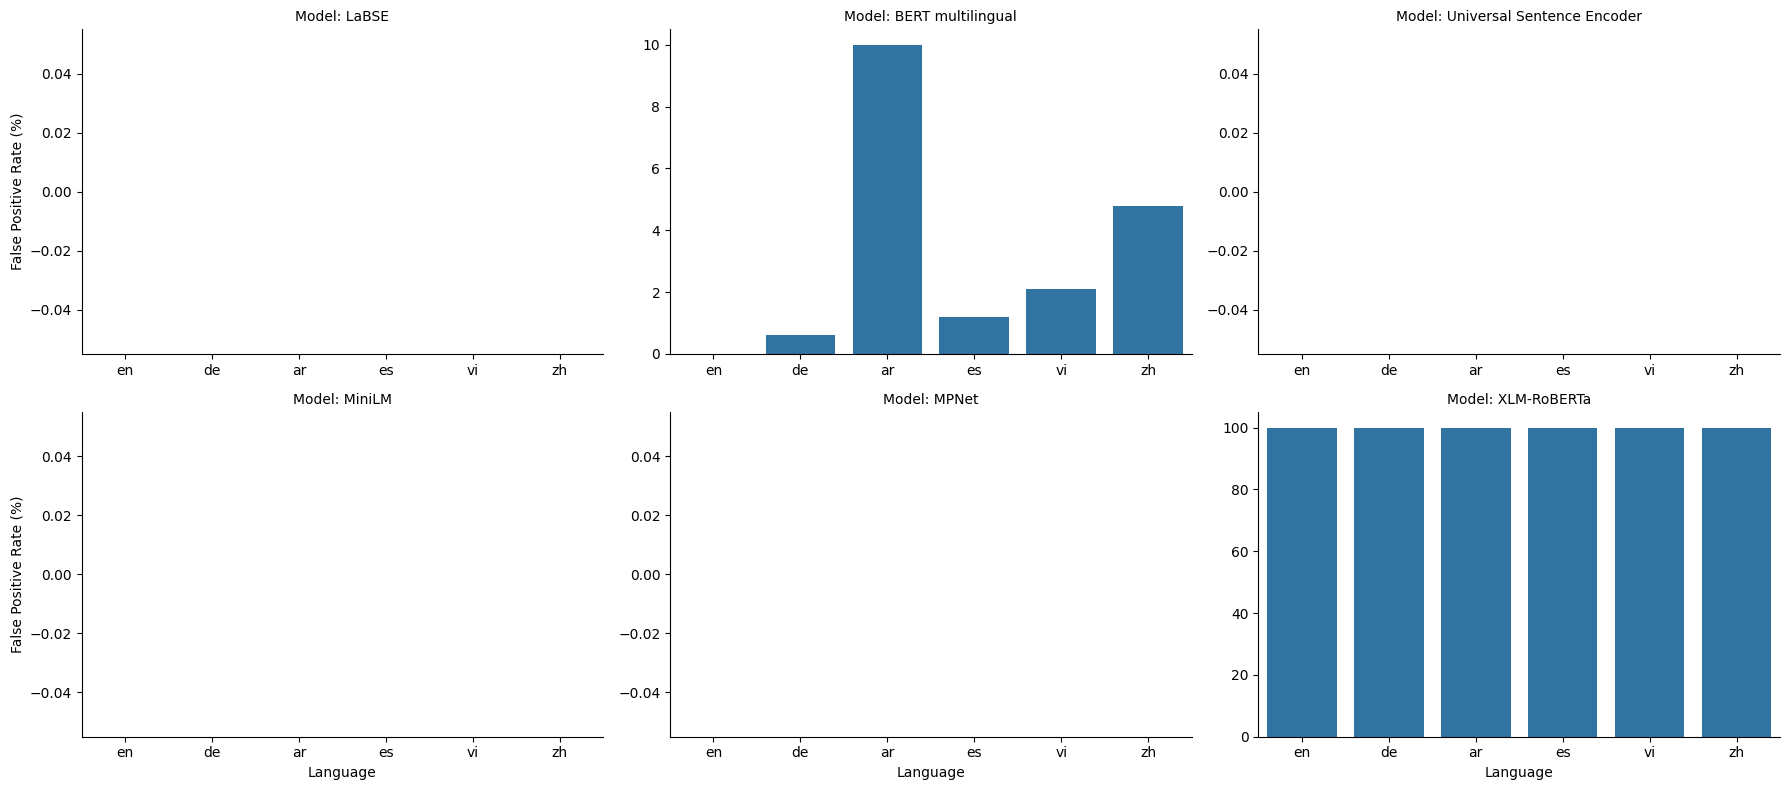

In [158]:
fpr_df_languages_models = fpr_for_specific_languages_models(full_results_mlqa)
plot_language_fprs(fpr_df_languages_models)

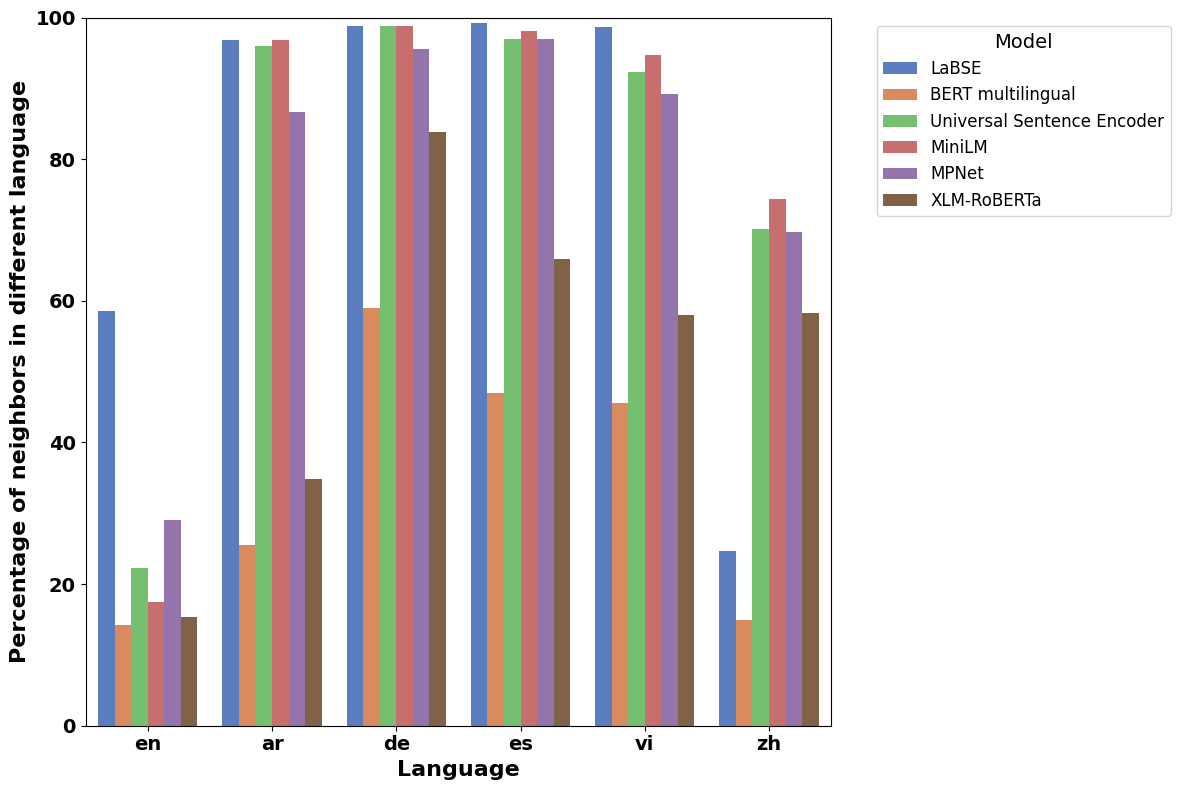

In [159]:
language_percentages_df = percentage_different_language_nearest_neighbor(full_results_mlqa)
plot_different_language_neighbors(language_percentages_df, "mlqa")

In [160]:
rouge_df = calculate_rouge_scores(full_results_mlqa)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [01:07<00:00, 11.31s/it]


/tmp/ipykernel_45258/72091400.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(


/tmp/ipykernel_45258/72091400.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(


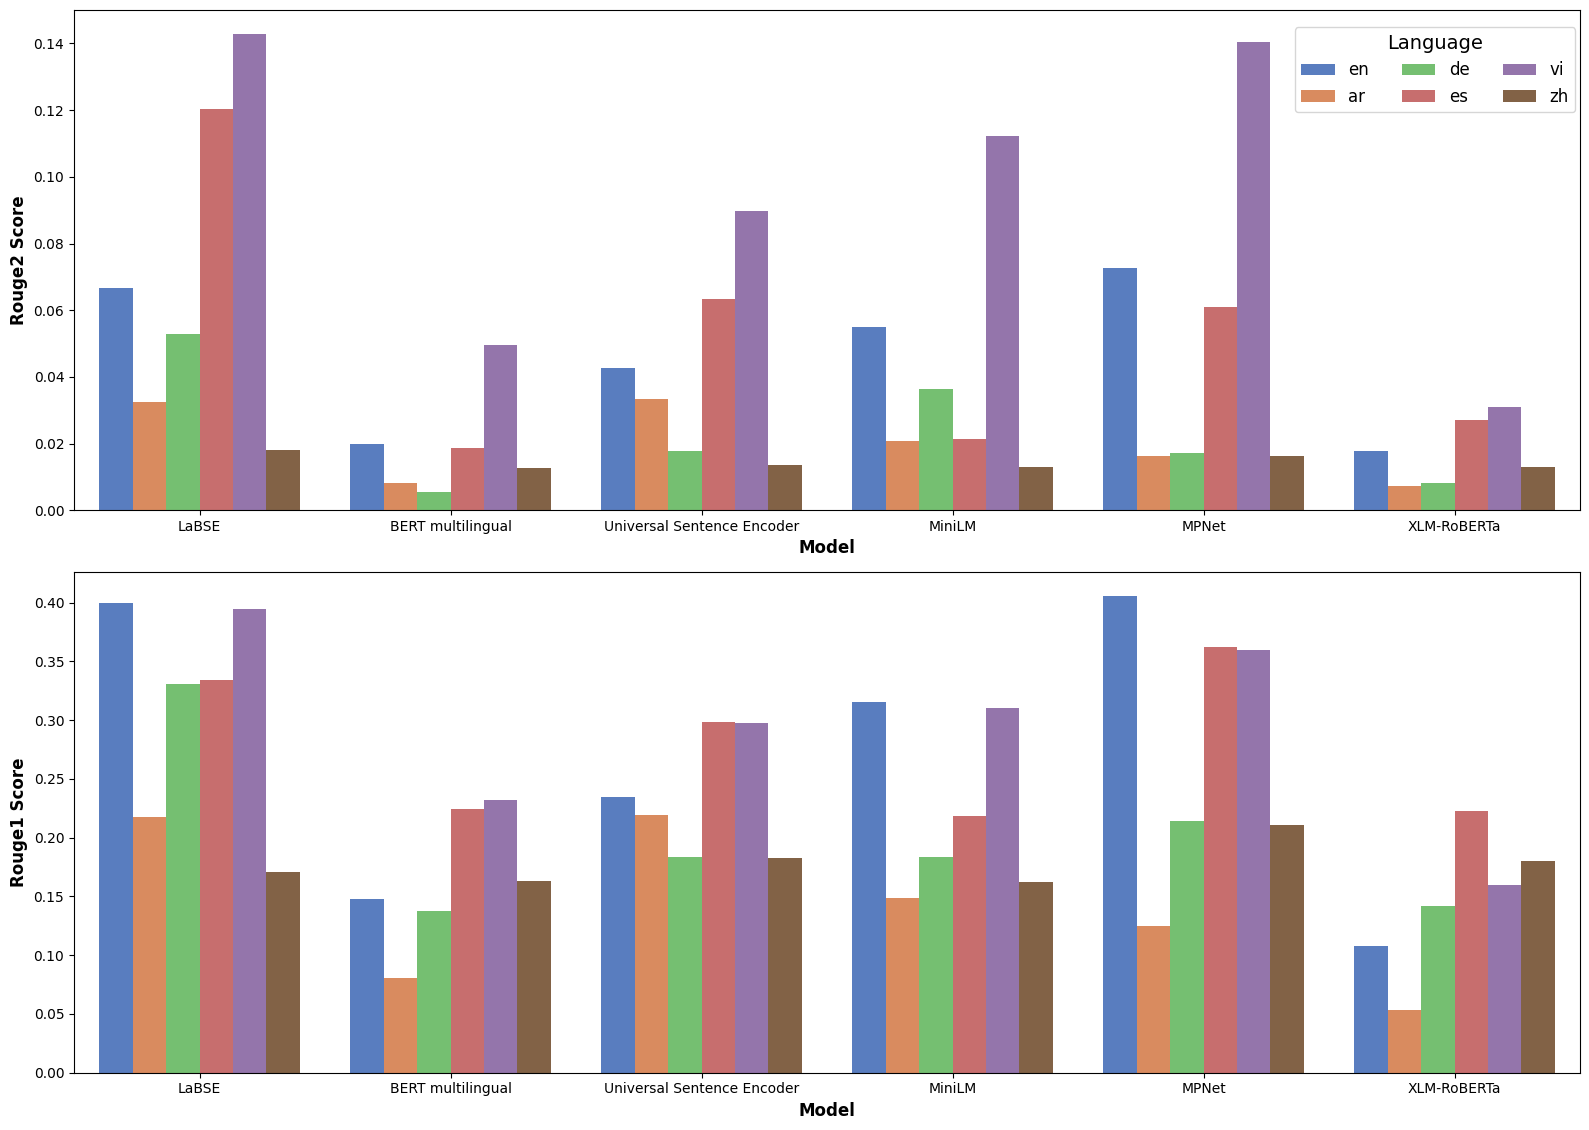

In [162]:
plot_rouge_scores(rouge_df, "mlqa")

<h1> Visualizations of MKQA evaluation <h1>

In [163]:
datasets = glob.glob("../data/retrieval_results/mkqa*.csv")
dfs = []
for dataset, model in zip(datasets, MODELS):
    print(dataset, model)
    df = pd.read_csv(dataset, index_col=0)
    df["model"] = model
    dfs.append(df)

../data/retrieval_results/mkqa_filtered_LaBSE.csv LaBSE
../data/retrieval_results/mkqa_filtered_bert-base-multilingual-cased.csv BERT multilingual


../data/retrieval_results/mkqa_filtered_distiluse-base-multilingual-cased-v2.csv Universal Sentence Encoder
../data/retrieval_results/mkqa_filtered_paraphrase-multilingual-MiniLM-L12-v2.csv MiniLM
../data/retrieval_results/mkqa_filtered_paraphrase-multilingual-mpnet-base-v2.csv MPNet
../data/retrieval_results/mkqa_filtered_xlm-roberta-base.csv XLM-RoBERTa


In [164]:
full_results_mkqa = pd.concat(dfs)
full_results_mkqa.reset_index(drop=True, inplace=True)
full_results_mkqa["lang"] = full_results_mkqa["lang"].apply(lambda x: "zh" if x=="zh_cn" else x)

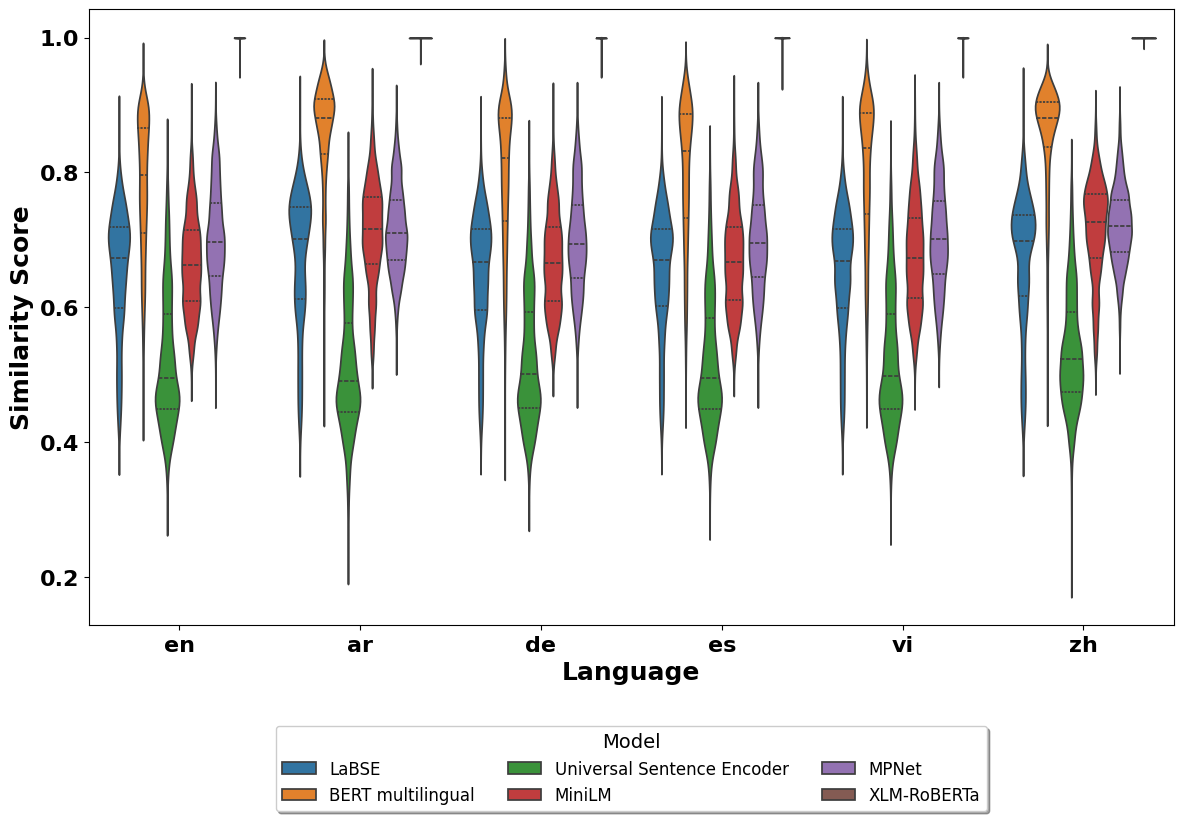

In [165]:
plot_similarity_scores_by_language_overlay(full_results_mkqa, "mkqa")

/tmp/ipykernel_45258/2626101478.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_xticklabels(axis.get_xticks(), fontweight="bold", fontsize=10)
/tmp/ipykernel_45258/2626101478.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(axis.get_yticks(), fontweight="bold", fontsize=10)


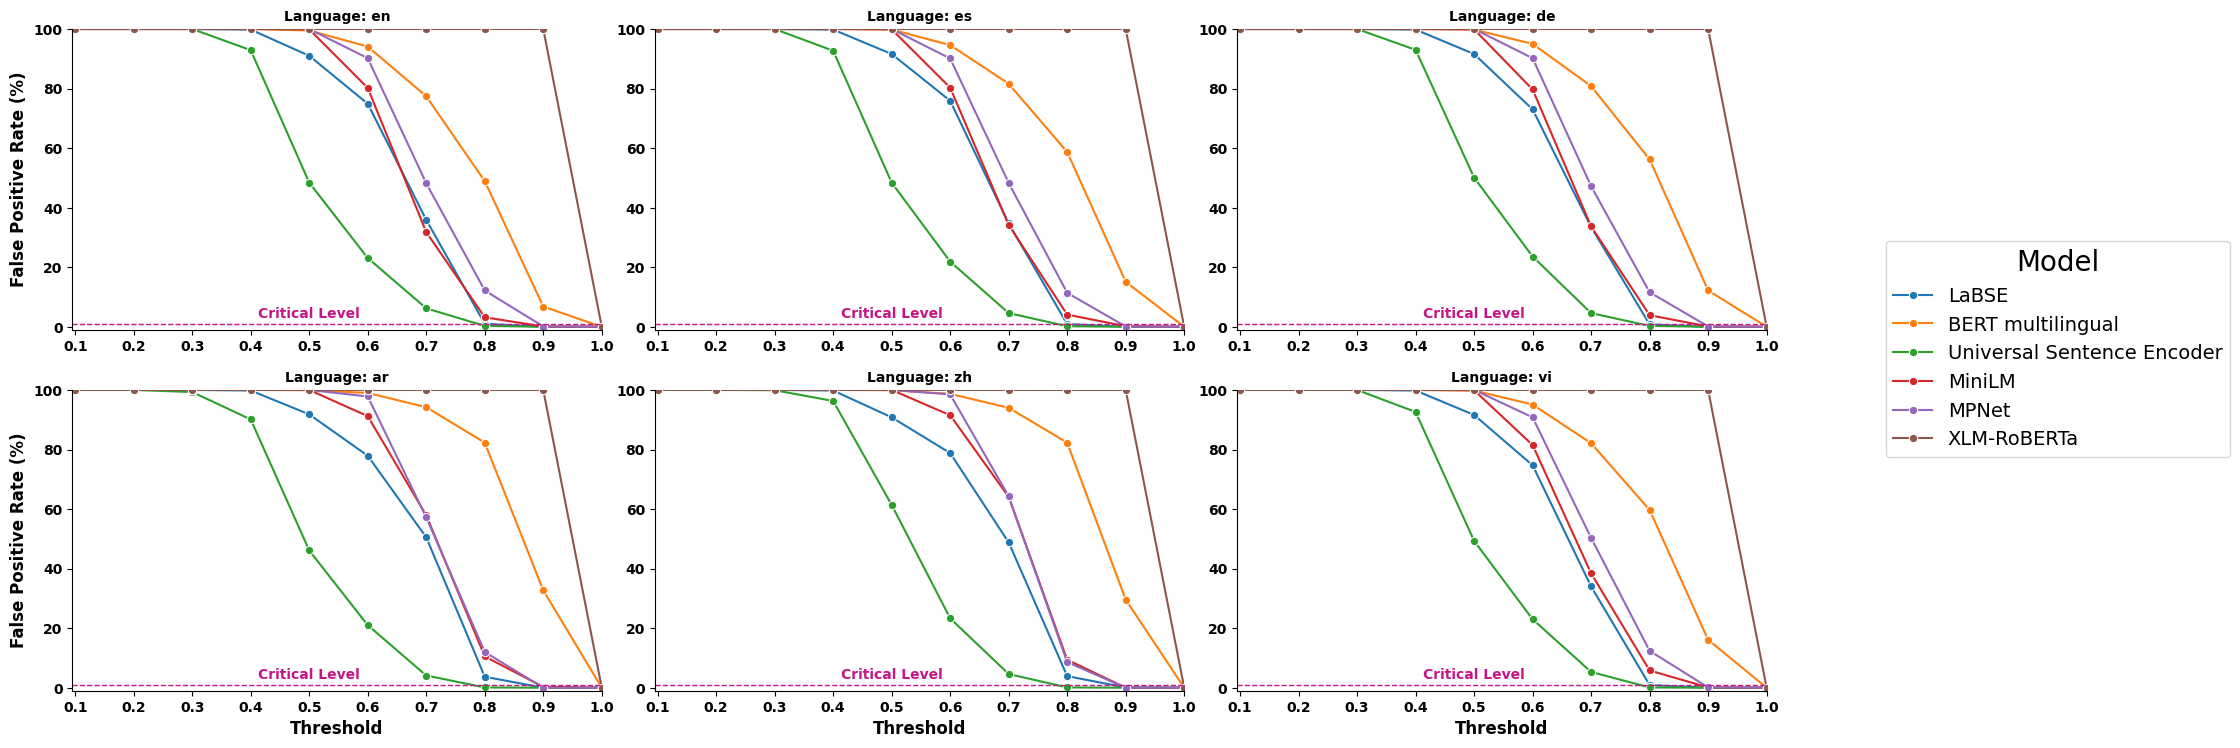

In [178]:
fpr_df_models = calculate_fpr_across_models(full_results_mkqa, TARGET_LANGUAGES, MODELS)
plot_fpr_rates_across_thresholds(fpr_df_models, "mkqa")

In [179]:
fpr_df_languages_models

,model,lang,fpr
0,LaBSE,en,0.0
1,LaBSE,ar,0.0
2,LaBSE,de,0.0
3,LaBSE,es,0.0
4,LaBSE,vi,0.0
5,LaBSE,zh,0.0
6,BERT multilingual,en,0.0
7,BERT multilingual,ar,2.0
8,BERT multilingual,de,0.5
9,BERT multilingual,es,0.1


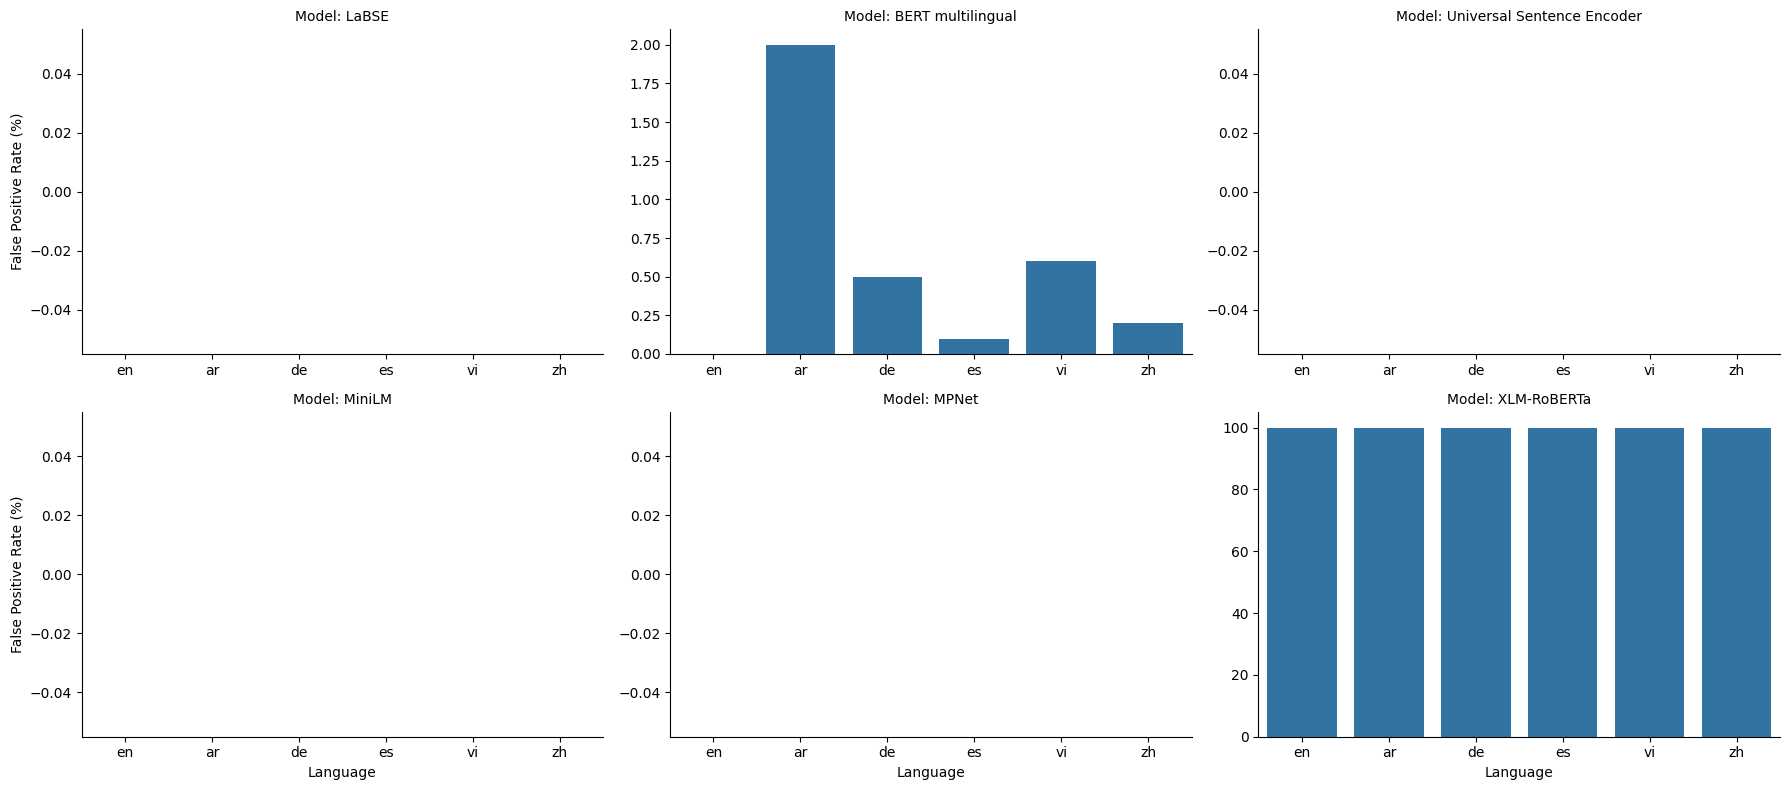

In [169]:
fpr_df_languages_models = fpr_for_specific_languages_models(full_results_mkqa)
plot_language_fprs(fpr_df_languages_models)

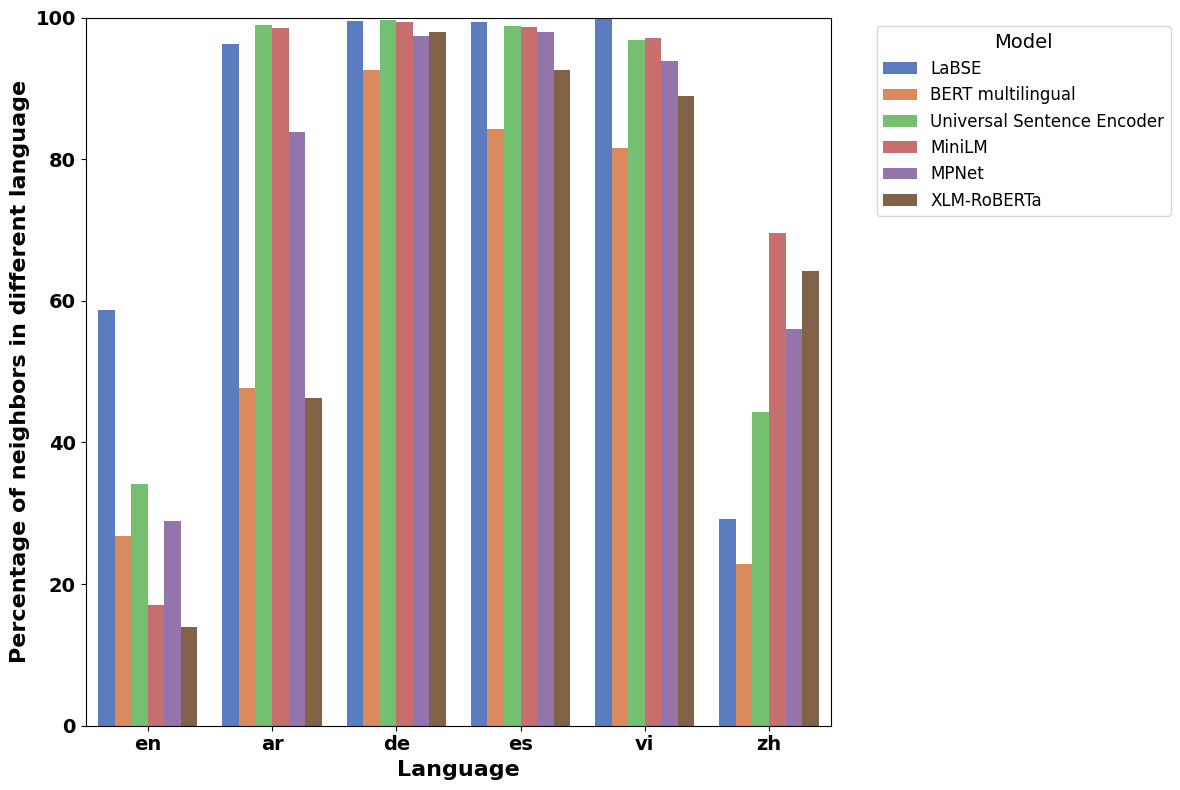

In [170]:
language_percentages_df = percentage_different_language_nearest_neighbor(full_results_mkqa)
plot_different_language_neighbors(language_percentages_df, "mkqa")

In [171]:
rouge_df = calculate_rouge_scores(full_results_mkqa)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:38<00:00,  6.36s/it]


/tmp/ipykernel_45258/72091400.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(
/tmp/ipykernel_45258/72091400.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(


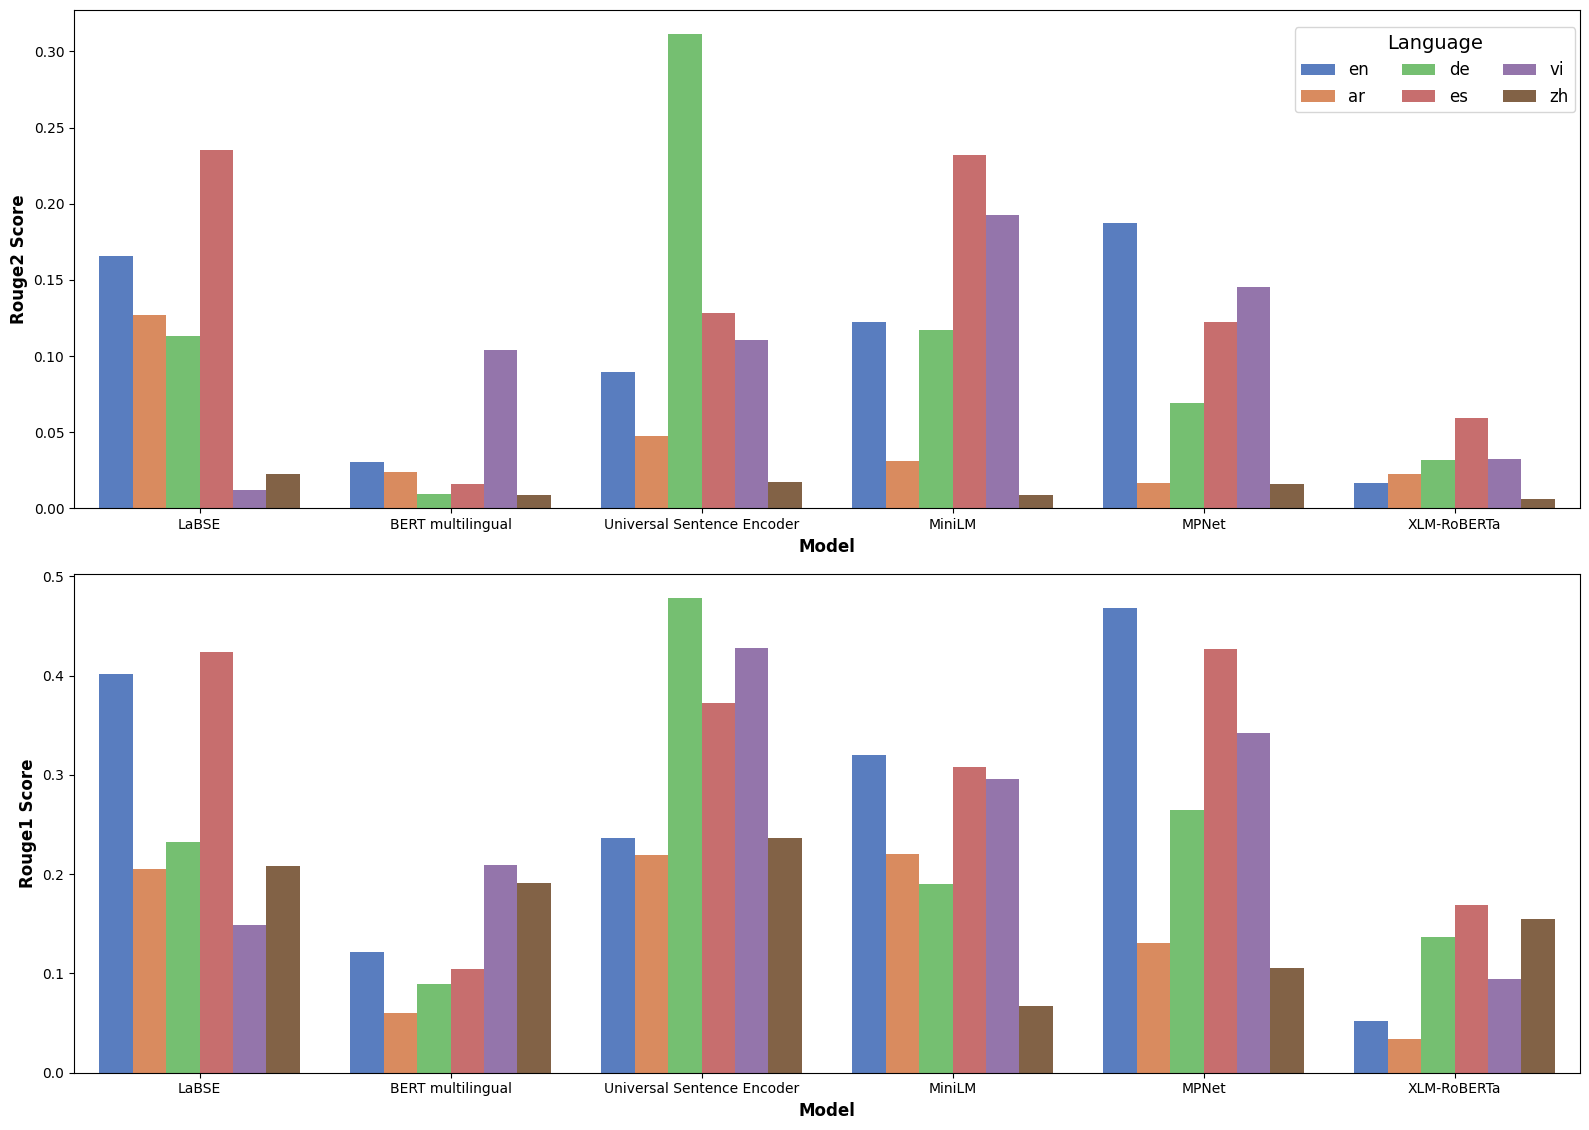

In [172]:
plot_rouge_scores(rouge_df, "mkqa")

<h2> Visualizations of embeddings <h2>

In [14]:
oasst_dataset = load_dataset("dkoterwa/oasst2_filtered", split="train").to_pandas()
embeddings = np.load("../data/test_embeddings/oasst2_filtered_xlm-roberta-base.npy")

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

In [ ]:
umap_df = pd.DataFrame(embedding_2d, columns=['UMAP_1', 'UMAP_2'])
umap_df['lang'] = oasst_dataset['lang']
lang_order = ['en', 'de', 'es', 'ar', 'vi', 'zh']

In [ ]:
nearest_neighbor_data = pd.read_csv("../data/retrieval_results/oasst2_filtered_xlm-roberta-base.csv", index_col=0)

In [ ]:
umap_df_nn = pd.DataFrame(embedding_2d, columns=['UMAP_1', 'UMAP_2'])
umap_df_nn['lang'] = nearest_neighbor_data['nearest_neighbor_lang']

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Plot the first subplot
scatter_plot1 = sns.scatterplot(
    ax=ax1,
    x='UMAP_1', y='UMAP_2',
    hue='lang',
    palette='muted',
    data=umap_df,
    legend='full',
    hue_order=lang_order,
    s=30
)

for artist in scatter_plot1.collections:
    artist.set_alpha(0.3)

handles1, labels1 = scatter_plot1.get_legend_handles_labels()
ax1.legend(handles1, labels1, title='Language', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=12, prop={'weight':'bold'})
ax1.set_xlabel('UMAP 1', fontweight="bold", fontsize=12)
ax1.set_ylabel('UMAP 2', fontweight="bold", fontsize=12)
plt.setp(ax1.get_xticklabels(), fontweight="bold", fontsize=10)
plt.setp(ax1.get_yticklabels(), fontweight="bold", fontsize=10)
ax1.set_title('UMAP Projection - Original Data', fontweight="bold", fontsize=12)

# Plot the second subplot
scatter_plot2 = sns.scatterplot(
    ax=ax2,
    x='UMAP_1', y='UMAP_2',
    hue='lang',
    palette='muted',
    data=umap_df_nn,
    legend=False,
    hue_order=lang_order,
    s=30
)

for artist in scatter_plot2.collections:
    artist.set_alpha(0.3)

handles2, labels2 = scatter_plot2.get_legend_handles_labels()
ax2.set_xlabel('UMAP 1', fontweight="bold", fontsize=12)
ax2.set_ylabel('UMAP 2', fontweight="bold", fontsize=12)
plt.setp(ax2.get_xticklabels(), fontweight="bold", fontsize=10)
plt.setp(ax2.get_yticklabels(), fontweight="bold", fontsize=10)
ax2.set_title('UMAP Projection - Nearest Neighbors', fontweight="bold", fontsize=12)

# Adjust layout
plt.tight_layout()

# Save the combined figure
plt.savefig("../data/plots/oasst_xlm_roberta_embeddings_umap_combined.png", dpi=300)

# Show the plot
plt.show()